# Robot Trading con Python

##1. Configuración del Ambiente

###1.1 Importar libreria a utilizar en el proyecto

In [8]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import time

### 1.2 Versiones de las librerias

In [9]:
!python -V
print('---------------')
!pip show Pandas | grep 'Name\|Version'
print('---------------')
!pip show Numpy | grep 'Name\|Version'
print('---------------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.11
---------------
Name: pandas
Version: 1.5.3
---------------
Name: numpy
Version: 1.22.4
---------------
Name: matplotlib
Version: 3.7.1


### 1.3 Definición de variables globales

In [10]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

##2. Obtención de Datos

### 2.1 Precios Históricos del Bitcon

In [11]:
# Extraer el histórico de precios del Bitcoin en dólares
def importar_base_bitcoin():
  global df_bitcoin
    
  # Obtener el histórico de precios del Bitcoin en los últimos 7 días con intervalos de 5 minutos
  data_btc = yf.Ticker("BTC-USD").history(period='7d', interval='5m')

  # Guardar el histórico en el dataframe df_bitcoin
  df_bitcoin = pd.DataFrame(data_btc)
  return df_bitcoin

In [12]:
# Muestra de la base histórica de precios del Bitcoin
importar_base_bitcoin()
df_bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-16 00:00:00+00:00,27171.513672,27180.341797,27171.226562,27171.226562,0,0.0,0.0
2023-05-16 00:05:00+00:00,27170.492188,27202.392578,27170.492188,27202.392578,11909120,0.0,0.0
2023-05-16 00:10:00+00:00,27221.753906,27222.830078,27208.285156,27222.830078,25136128,0.0,0.0
2023-05-16 00:15:00+00:00,27221.365234,27270.158203,27221.365234,27270.158203,0,0.0,0.0
2023-05-16 00:20:00+00:00,27264.189453,27287.683594,27264.189453,27287.683594,0,0.0,0.0


### 2.2 Indicadores de Tendencias

In [13]:
def extraer_tendencias():
    global precio_actual, tendencia
    
    # Realizar la solicitud HTTP a la página de CoinMarketCap y obtener el contenido HTML
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}
    url = "https://coinmarketcap.com/"
    response = requests.get(url, headers=headers)
    html = response.text
    
    # Utilizar BeautifulSoup para analizar el contenido HTML
    soup = BeautifulSoup(html, "html.parser")
    
    # Encontrar el elemento que contiene el precio actual del Bitcoin
    precio_element = soup.find('div', class_='sc-cadad039-0 clgqXO')
    precio_texto = precio_element.get_text().strip().replace("$", "").replace(",", "")
    precio_actual = float(precio_texto)
    
    # Encontrar el elemento que contiene la variación del precio en la última hora
    variacion_element = soup.findAll('span', {'class':['sc-97d6d2ca-0 cYiHal','sc-97d6d2ca-0 bQjSqS']})[0]
    variacion_texto = variacion_element.get_text().strip()
    
    # Verificar la tendencia basada en el icono
    if 'icon-Caret-down' in variacion_texto:
        tendencia = 'baja'
    else:
        tendencia = 'alta'
 
    return precio_actual, tendencia

In [14]:
# Muestra el Precio Actual del Bitcoin y su tendencia
extraer_tendencias()
print('Bitcoin Precio: ', precio_actual)
print('Tendencia: ', tendencia)

Bitcoin Precio:  26852.92
Tendencia:  alta


## 3. Limpieza de Datos

Text(0.5, 1.0, 'Distribución del Precio del Bitcoin')

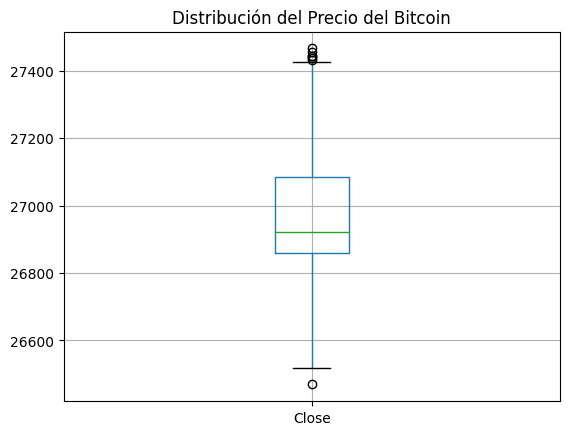

In [15]:
# Muestra el boxplot de la base sin tratamiento
df_bitcoin.boxplot(['Close'])
plt.title('Distribución del Precio del Bitcoin')

In [16]:
def limpieza_datos():
    global df_bitcoin, df_bitcoin_limpio, media_bitcoin
    
    # Crear una copia del dataframe df_bitcoin
    df_bitcoin_limpio = df_bitcoin.copy()
    
    # Tratar duplicados en el índice (Datetime)
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]
    
    # Tratar valores nulos en la columna Close
    df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)
    
    # Eliminar registros con Volume de transacción igual o menor a 0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
    
    # Identificar y eliminar outliers en el precio del Bitcoin (Close)
    q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    q3 = df_bitcoin_limpio['Close'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= lower_bound) & (df_bitcoin_limpio['Close'] <= upper_bound)]
    
    # Calcular el precio promedio (Close)
    media_bitcoin = df_bitcoin_limpio['Close'].mean()

    print('Precio promedio del Bitcoin:', media_bitcoin)
    print('\n')

In [17]:
def grafico_boxplot(dataframe):
    # Obtener los valores máximo, mediana, mínimo, Q1 y Q3
    max_val = dataframe['Close'].max()
    median_val = dataframe['Close'].median()
    min_val = dataframe['Close'].min()
    q1_val = dataframe['Close'].quantile(0.25)
    q3_val = dataframe['Close'].quantile(0.75)

    # Crear gráfico boxplot horizontal
    plt.figure(figsize=(10, 6))
    plt.boxplot(dataframe['Close'], vert=True, patch_artist=True)

    # Personalizar el gráfico
    plt.title('Distribución del Precio del Bitcoin')
    plt.xlabel('Cierre')
    plt.ylabel('Precio de Bitcoin')

    # Agregar guías para valor máximo, mediana, mínimo, Q1 y Q3
    plt.axhline(y=max_val, color='red', linestyle='--')
    plt.axhline(y=median_val, color='blue', linestyle='--')
    plt.axhline(y=min_val, color='green', linestyle='--')
    plt.axhline(y=q1_val, color='orange', linestyle='--', label=f'Q1: {q1_val:.2f}')
    plt.axhline(y=q3_val, color='purple', linestyle='--', label=f'Q3: {q3_val:.2f}')

    # Etiquetas de los valores en las líneas
    plt.annotate(f'Máximo: {max_val:.2f}', xy=(1, max_val), xytext=(10, 0),
                 xycoords=('axes fraction', 'data'), textcoords='offset points', color='red')
    plt.annotate(f'Mediana: {median_val:.2f}', xy=(1, median_val), xytext=(10, 0),
                 xycoords=('axes fraction', 'data'), textcoords='offset points', color='blue')
    plt.annotate(f'Mínimo: {min_val:.2f}', xy=(1, min_val), xytext=(10, 0),
                 xycoords=('axes fraction', 'data'), textcoords='offset points', color='green')
    plt.annotate(f'Q1: {q1_val:.2f}', xy=(1, q1_val), xytext=(10, 0),
                 xycoords=('axes fraction', 'data'), textcoords='offset points', color='orange')
    plt.annotate(f'Q3: {q3_val:.2f}', xy=(1, q3_val), xytext=(10, 0),
                 xycoords=('axes fraction', 'data'), textcoords='offset points', color='purple')

    # Cambiar colores del boxplot
    box_color = 'lightblue'
    whisker_color = 'gray'
    flier_color = 'red'

    for patch in plt.boxplot(dataframe['Close'], vert=True, patch_artist=True)['boxes']:
        patch.set(facecolor=box_color, linewidth=1.5)

    for whisker in plt.boxplot(dataframe['Close'], vert=True, patch_artist=True)['whiskers']:
        whisker.set(color=whisker_color, linewidth=1.5, linestyle='-')

    for cap in plt.boxplot(dataframe['Close'], vert=True, patch_artist=True)['caps']:
        cap.set(color=whisker_color, linewidth=1.5)

    for flier in plt.boxplot(dataframe['Close'], vert=True, patch_artist=True)['fliers']:
        flier.set(marker='o', color=flier_color, alpha=0.8)

    # Mostrar el gráfico
    plt.show()    

    # Imprimir breve conclusión
    print("\nEl boxplot muestra la distribución del precio del Bitcoin después de la limpieza de datos.\n"
          f"\nEl valor máximo es {max_val:.2f}, la mediana es {median_val:.2f}, y el valor mínimo es {min_val:.2f}.\n"
          "\nLa distribución de precios del Bitcoin se encuentra mayormente concentrada en el rango intercuartil (Q1-Q3),\n"
          "representado por el rectángulo en el centro del gráfico. La mediana indica el valor central de la distribución.\n"
          "Es importante destacar que este análisis se basa únicamente en el precio de cierre del Bitcoin y \n"
          "no tiene en cuenta otros factores relevantes para su valoración.")

Precio promedio del Bitcoin: 26985.050812007874




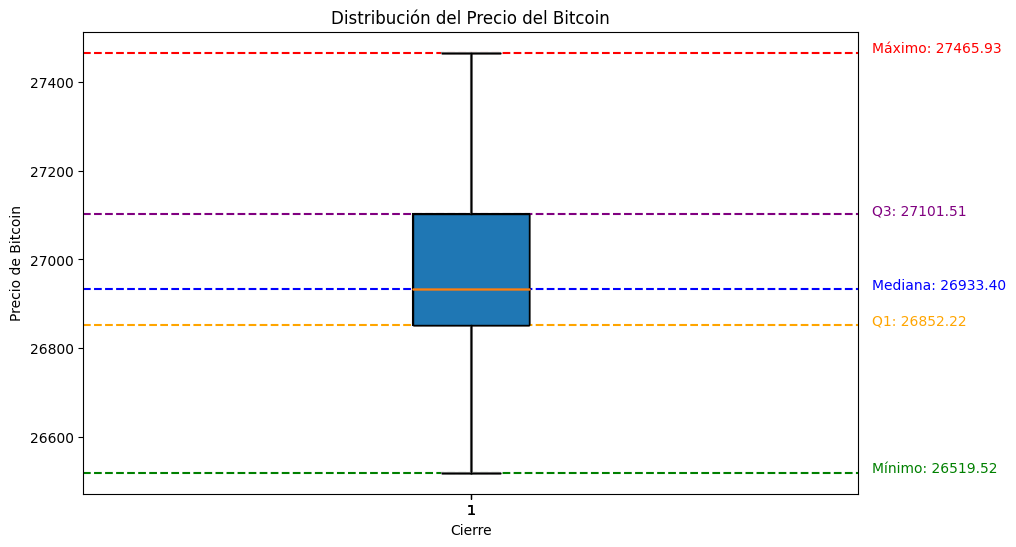


El boxplot muestra la distribución del precio del Bitcoin después de la limpieza de datos.

El valor máximo es 27465.93, la mediana es 26933.40, y el valor mínimo es 26519.52.

La distribución de precios del Bitcoin se encuentra mayormente concentrada en el rango intercuartil (Q1-Q3),
representado por el rectángulo en el centro del gráfico. La mediana indica el valor central de la distribución.
Es importante destacar que este análisis se basa únicamente en el precio de cierre del Bitcoin y 
no tiene en cuenta otros factores relevantes para su valoración.


In [18]:
limpieza_datos()
grafico_boxplot(df_bitcoin_limpio)

## 4. Toma de Decisiones

In [19]:
def tomar_decisiones():
    global algoritmo_decision
    
    # Verificar las condiciones de decisión
    if precio_actual >= media_bitcoin and tendencia == 'baja':
        algoritmo_decision = 'Vender'
    elif precio_actual < media_bitcoin and tendencia == 'alta':
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'
    return algoritmo_decision

In [20]:
# mostrar la decisión del algoritmo
tomar_decisiones()
print('Precio Promedio Bitcoin: ', media_bitcoin)
print('Precio Actual Bitcoin: ', precio_actual)
print('Tendencia: ', tendencia)
print('Desición del algoritmo: ', algoritmo_decision)

Precio Promedio Bitcoin:  26985.050812007874
Precio Actual Bitcoin:  26852.92
Tendencia:  alta
Desición del algoritmo:  Comprar


### 4.2 Toma de decisión aplicando el indicador RSI

In [21]:
def calcular_rsi(data, time_period=1):
    # Calcula los cambios diarios en el precio
    delta = data.diff().dropna()

    # Divide los cambios en positivos y negativos
    up = delta * 0
    down = delta * 0
    up[delta > 0] = delta[delta > 0]
    down[delta < 0] = -delta[delta < 0]

    # Calcula el promedio móvil exponencial de los cambios positivos y negativos
    avg_gain = up.rolling(window=time_period).mean()
    avg_loss = down.rolling(window=time_period).mean()

    # Calcula el RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Asegurar que el RSI tenga la misma longitud que los datos originales
    rsi = rsi.reindex(data.index)

    return rsi

In [22]:
def tomar_decisiones_rsi():
    global algoritmo_decision
    
    # Calcular el RSI
    rsi = calcular_rsi(df_bitcoin_limpio['Close'], time_period=1)  # Calcula el RSI con un período de 1 día
    
    # Verificar las condiciones de decisión
    if precio_actual >= media_bitcoin and tendencia == 'baja' and rsi.iloc[-1] > 70:
        algoritmo_decision = 'Vender'
    elif precio_actual < media_bitcoin and tendencia == 'alta' and rsi.iloc[-1] < 30:
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'
    
    return algoritmo_decision

In [23]:
tomar_decisiones_rsi()
print('Toma de decisión basada en indicador RSI')
print('Desición del algoritmo: ', algoritmo_decision)

Toma de decisión basada en indicador RSI
Desición del algoritmo:  Comprar


## 5. Visualización


In [40]:
def visualizacion():
    global media_bitcoin

    # Adicionar la columna Promedio al dataframe original
    df_bitcoin['Promedio'] = media_bitcoin

    # Configurar tamaño del gráfico
    plt.figure(figsize=(14, 5))

    # Dibujar línea del precio Close
    plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio', color='blue')

    # Dibujar línea del promedio
    plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Promedio', color='red')
   
    # Mostrar mensaje de decisión en el gráfico
    decision = tomar_decisiones()
    decision_color = 'green' if decision == 'Comprar' else 'red'
    decision_marker = 'v' if decision == 'Comprar' else '^'
    plt.scatter(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1], marker=decision_marker, color=decision_color, s=100)

    plt.annotate(algoritmo_decision, (df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),
                xytext=(-50, -50), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.5'),
                fontsize=12, color='black')

    # Mostrar valor del promedio en el gráfico
    plt.text(df_bitcoin.index[-1], media_bitcoin, f'Promedio: {media_bitcoin:.2f}',
             fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    # Configurar título del gráfico
    plt.title('Gráfico de Precios y Promedio')

    # Mostrar leyenda
    plt.legend()

    # Mostrar el gráfico
    plt.show()
    
    print("\nEl gráfico muestra la evolución del precio del Bitcoin y su promedio a lo largo del tiempo.\n" 
          "El precio se representa mediante una línea azul, mientras que el promedio se muestra con una línea roja.\n" 
          "El valor del promedio se encuentra cerca del cierre más reciente del Bitcoin.\n\n"
          "La presencia de fluctuaciones en el precio del Bitcoin es evidente en el gráfico,\n" 
          "con movimientos ascendentes y descendentes a lo largo del tiempo.\n" 
          "El promedio proporciona una medida de tendencia central y suaviza las variaciones más extremas del precio.\n\n"
          "La decisión calculada por el algoritmo se muestra en el gráfico como un mensaje. \n" 
          "Esta decisión se basa en las condiciones establecidas previamente y \n" 
          "puede indicar si es momento de comprar, vender o esperar.\n\n"
          "El gráfico brinda una visión visual de la relación entre el precio del Bitcoin y su promedio, \n" 
          "lo que puede ser útil para comprender la tendencia y tomar decisiones informadas sobre transacciones. \n" 
          "Es importante considerar otros factores y análisis adicionales antes de tomar decisiones de inversión basadas únicamente en este gráfico.\n\n")

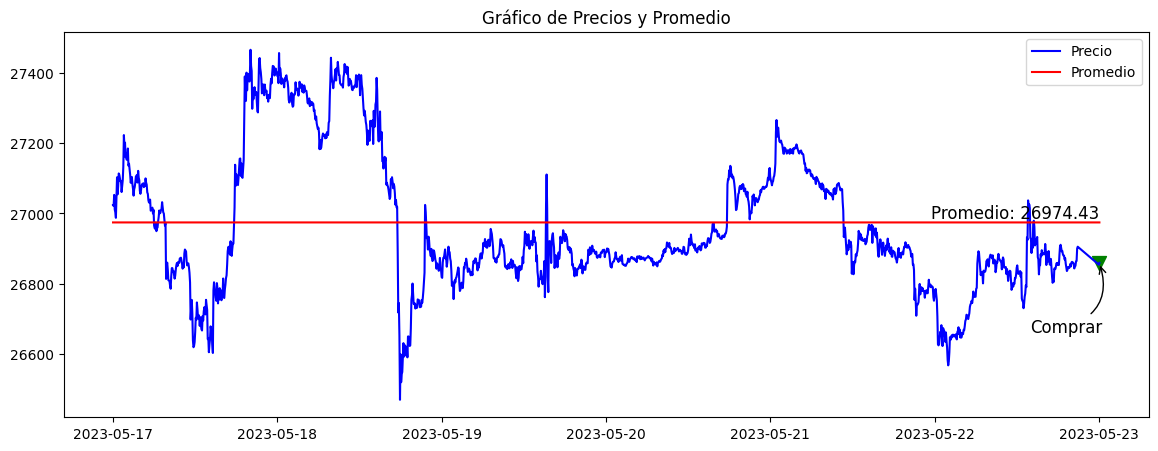


El gráfico muestra la evolución del precio del Bitcoin y su promedio a lo largo del tiempo.
El precio se representa mediante una línea azul, mientras que el promedio se muestra con una línea roja.
El valor del promedio se encuentra cerca del cierre más reciente del Bitcoin.

La presencia de fluctuaciones en el precio del Bitcoin es evidente en el gráfico,
con movimientos ascendentes y descendentes a lo largo del tiempo.
El promedio proporciona una medida de tendencia central y suaviza las variaciones más extremas del precio.

La decisión calculada por el algoritmo se muestra en el gráfico como un mensaje. 
Esta decisión se basa en las condiciones establecidas previamente y 
puede indicar si es momento de comprar, vender o esperar.

El gráfico brinda una visión visual de la relación entre el precio del Bitcoin y su promedio, 
lo que puede ser útil para comprender la tendencia y tomar decisiones informadas sobre transacciones. 
Es importante considerar otros factores y análisis adiciona

In [41]:
# Mostrar el resultado de la toma de decisiones gráficamente
visualizacion()

In [26]:
def visualizacion_rsi():
    # Variables globales
    global df_bitcoin
    global media_bitcoin
    global precio_actual
    global tendencia

    # Cálculo del promedio
    df_bitcoin['Promedio'] = df_bitcoin['Close'].rolling(window=7).mean()

    # Configuración del gráfico
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1]})

    # Gráfico de precio del Bitcoin y promedio
    ax1.plot(df_bitcoin.index, df_bitcoin['Close'], color='blue', label='Precio de Cierre')
    ax1.plot(df_bitcoin.index, df_bitcoin['Promedio'], color='red', label='Promedio')
    ax1.axhline(y=df_bitcoin['Close'].max(), color='red', linestyle='--', label=f'Máximo: {df_bitcoin["Close"].max():.2f}')
    ax1.axhline(y=df_bitcoin['Close'].median(), color='blue', linestyle='--', label=f'Mediana: {df_bitcoin["Close"].median():.2f}')
    ax1.axhline(y=df_bitcoin['Close'].min(), color='green', linestyle='--', label=f'Mínimo: {df_bitcoin["Close"].min():.2f}')
    ax1.set_title('Evolución del Precio del Bitcoin y Promedio en las últimas 24hs')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Precio')
    ax1.legend()

    # Gráfico del RSI
    rsi = calcular_rsi(df_bitcoin['Close'], time_period=24)  # Calcula el RSI para un período de 24 horas
    ax2.fill_between(df_bitcoin.index, 0, rsi, where=rsi >= 70, facecolor='red', alpha=0.3, label='Sobrecompra')
    ax2.fill_between(df_bitcoin.index, 0, rsi, where=rsi <= 30, facecolor='green', alpha=0.3, label='Sobreventa')
    ax2.plot(df_bitcoin.index, rsi, color='black', linewidth=0.5, label='RSI')
    ax2.axhline(y=70, color='red', linestyle='--')
    ax2.axhline(y=30, color='green', linestyle='--')
    ax2.set_title('Indicador RSI')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('RSI')
    ax2.legend()

    # Anotación de la decisión calculada
    decision = tomar_decisiones_rsi()
    ax2.text(0.5, 0.1, f'Decisión: {decision}', transform=ax2.transAxes, fontsize=12, ha='center', bbox=dict(facecolor='lightgrey', edgecolor='black'))

    # Ajustar la visualización para mostrar solo el último día
    last_day = df_bitcoin.index[-1]
    ax1.set_xlim([last_day - pd.DateOffset(days=1), last_day])
    ax2.set_xlim([last_day - pd.DateOffset(days=1), last_day])
    ax2.set_ylim([0, 100])

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

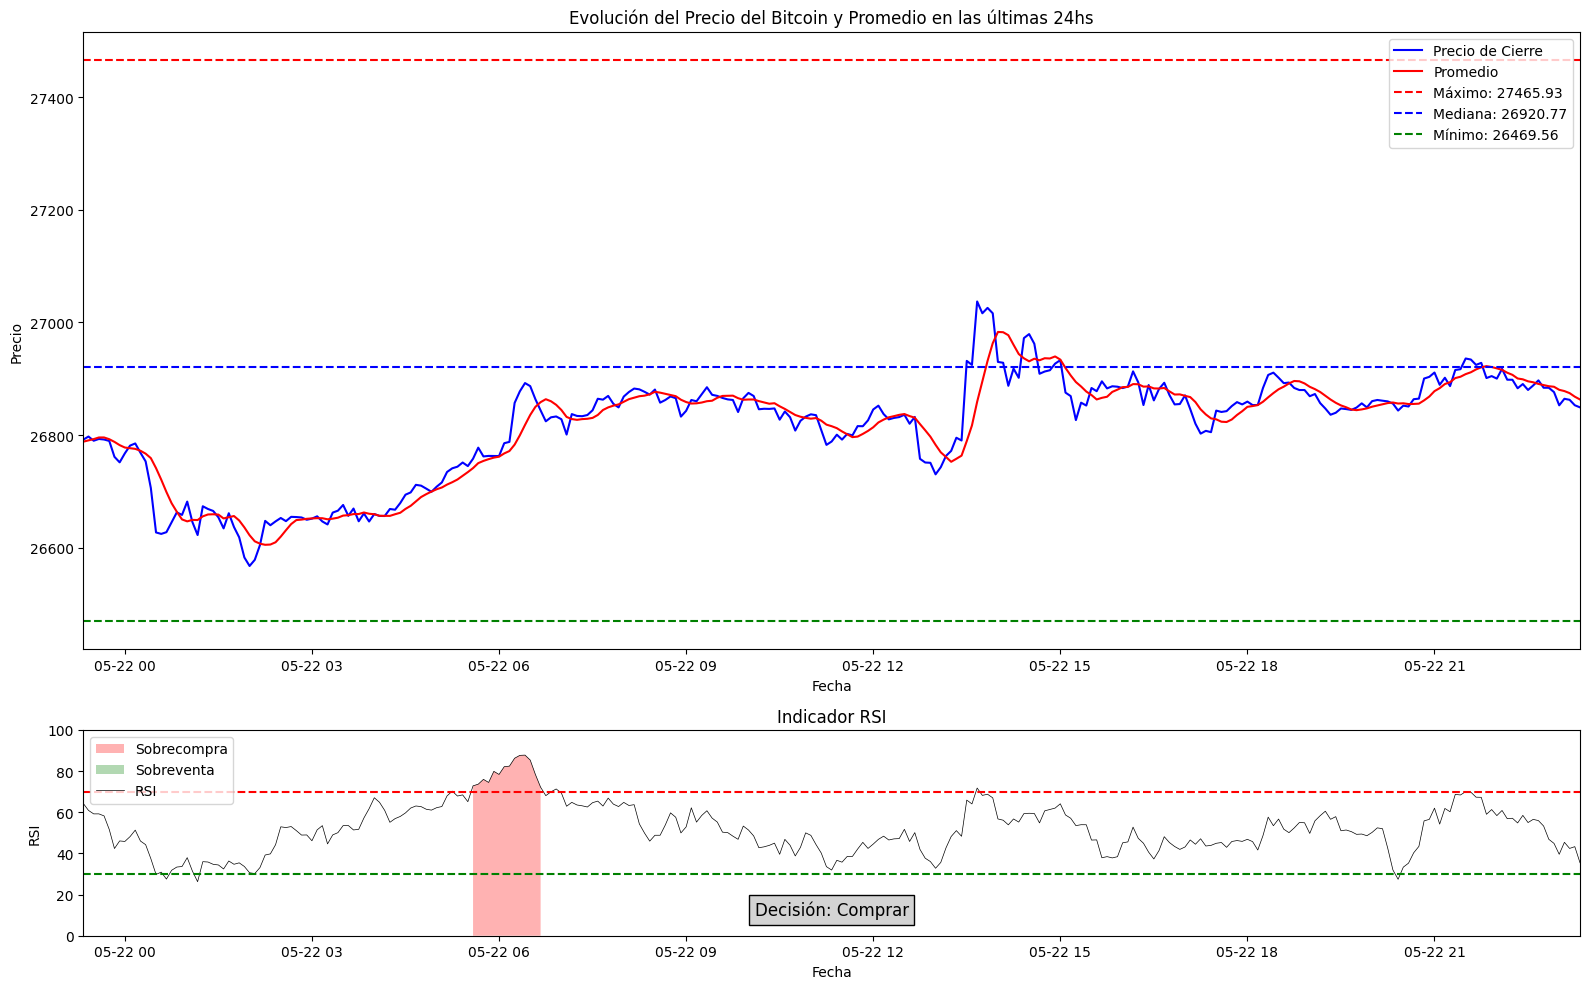

El Indicador de Fuerza Relativa (RSI) es un oscilador utilizado en el análisis técnico para evaluar la velocidad y el cambio de los precios.
El RSI se calcula utilizando la fórmula:
RSI = 100 - (100 / (1 + RS))
donde RS es la relación entre el promedio de los incrementos de precio y el promedio de los decrementos de precio durante un período de tiempo específico.
El RSI oscila entre 0 y 100. Un valor por encima de 70 se considera sobrecompra, lo que sugiere que el activo puede estar sobrevalorado y podría producirse una reversión a la baja.
Por otro lado, un valor por debajo de 30 se considera sobreventa, lo que sugiere que el activo puede estar infravalorado y podría producirse una reversión al alza.
Se suele utilizar el RSI para identificar niveles de sobrecompra y sobreventa y tomar decisiones de compra o venta en función de estos niveles y de posibles divergencias entre el RSI y el precio del activo.


In [27]:
visualizacion_rsi()
# Explicación del indicador RSI
print("El Indicador de Fuerza Relativa (RSI) es un oscilador utilizado en el análisis técnico para evaluar la velocidad y el cambio de los precios.")
print("El RSI se calcula utilizando la fórmula:")
print("RSI = 100 - (100 / (1 + RS))")
print("donde RSI es la relación entre el promedio de los incrementos de precio y el promedio de los decrementos de precio durante un período de tiempo específico.")
print("El RSI oscila entre 0 y 100. Un valor por encima de 70 se considera sobrecompra, lo que sugiere que el activo puede estar sobrevalorado y podría producirse una reversión a la baja.")
print("Por otro lado, un valor por debajo de 30 se considera sobreventa, lo que sugiere que el activo puede estar infravalorado y podría producirse una reversión al alza.")
print("Se suele utilizar el RSI para identificar niveles de sobrecompra y sobreventa y tomar decisiones de compra o venta en función de estos niveles y de posibles divergencias entre el RSI y el precio del activo.")

## 6. Automatización


In [28]:
def automatizacion():
  while (True):
    clear_output()
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    visualizacion()
    visualizacion_rsi()
    time.sleep(300)

Precio promedio del Bitcoin: 26974.42788945627




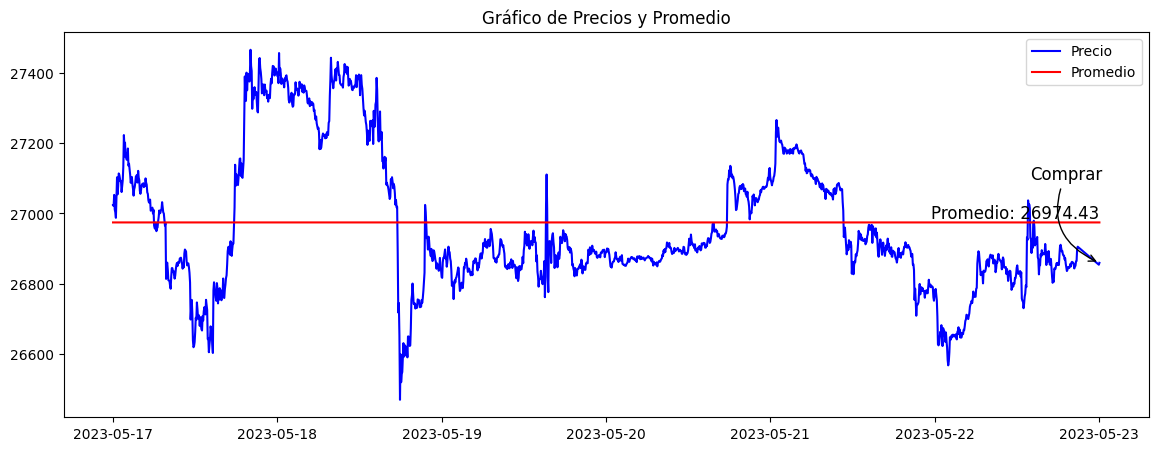


El gráfico muestra la evolución del precio del Bitcoin y su promedio a lo largo del tiempo.
El precio se representa mediante una línea azul, mientras que el promedio se muestra con una línea roja.
El valor del promedio se encuentra cerca del cierre más reciente del Bitcoin.

La presencia de fluctuaciones en el precio del Bitcoin es evidente en el gráfico,
con movimientos ascendentes y descendentes a lo largo del tiempo.
El promedio proporciona una medida de tendencia central y suaviza las variaciones más extremas del precio.

La decisión calculada por el algoritmo se muestra en el gráfico como un mensaje. 
Esta decisión se basa en las condiciones establecidas previamente y 
puede indicar si es momento de comprar, vender o esperar.

El gráfico brinda una visión visual de la relación entre el precio del Bitcoin y su promedio, 
lo que puede ser útil para comprender la tendencia y tomar decisiones informadas sobre transacciones. 
Es importante considerar otros factores y análisis adiciona

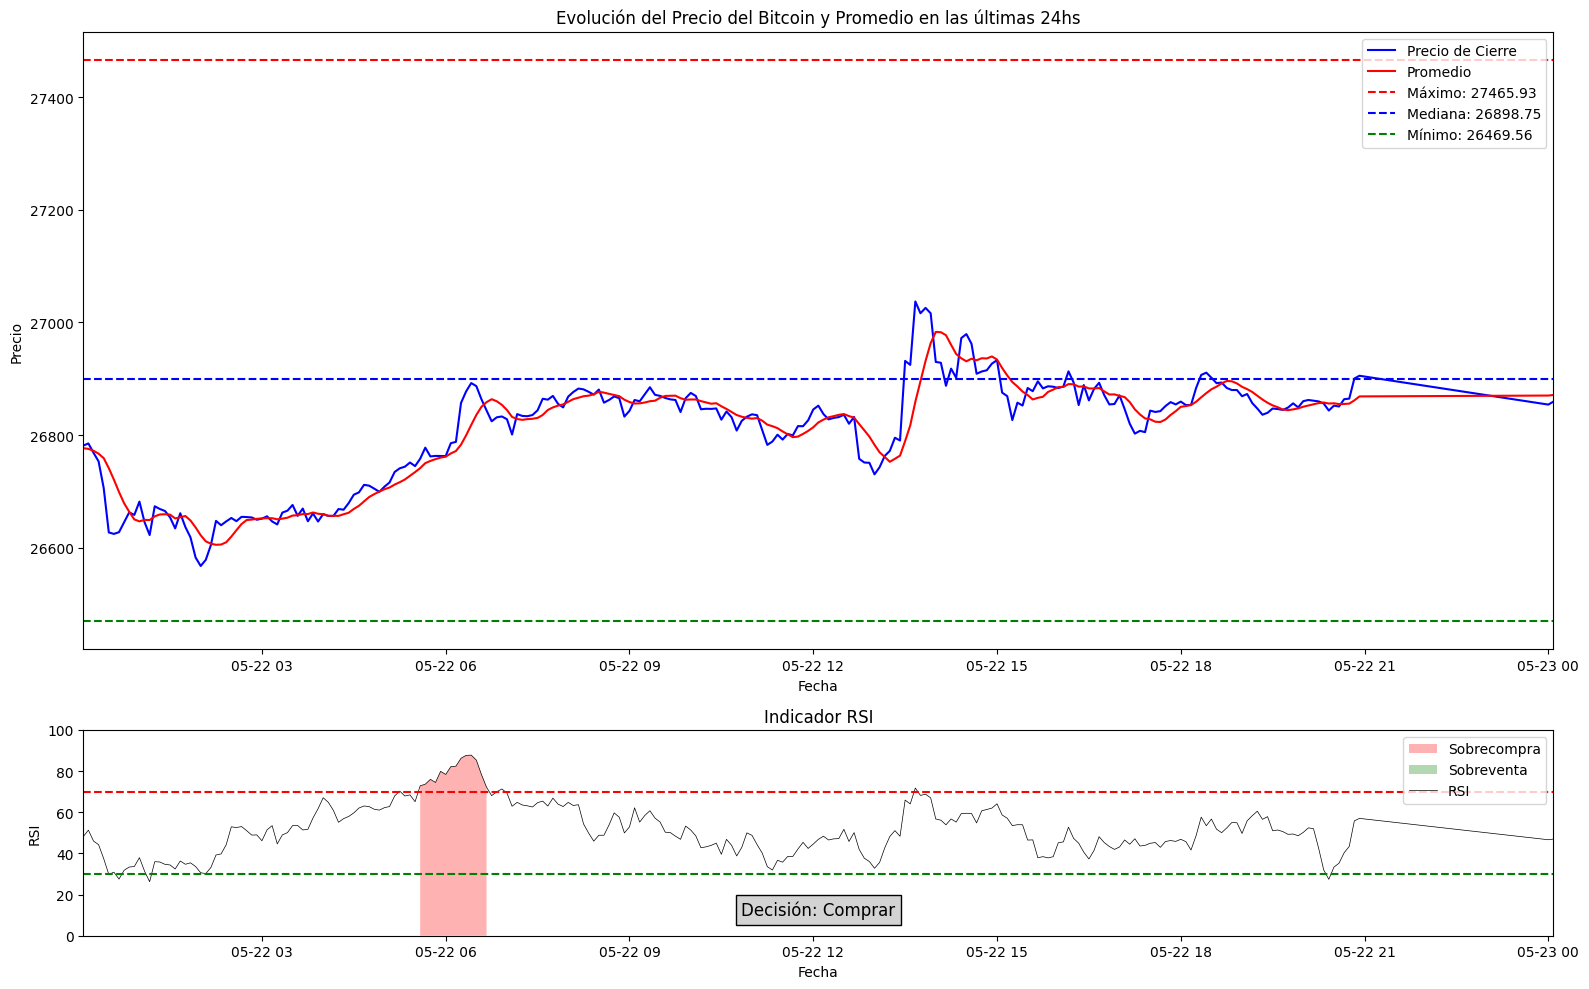

KeyboardInterrupt: ignored

In [30]:
automatizacion()